# OpenAI-to-Z Challenge: Geometric Pattern Analysis

This notebook implements advanced geometric filtering and pattern recognition to identify potential archaeological earthworks. Building on the previous Hough Transform analysis, this script will:

1.  Detect all initial line features in the DTM hillshade.
2.  Filter these lines based on length constraints (30-400m) typical of Acre geoglyphs.
3.  Identify and group lines that form geometric patterns (parallel and perpendicular clusters).
4.  Visualize only the geometrically significant lines to reduce noise and highlight potential structures.

## 1. Setup and Imports

In [1]:
import os
import rasterio
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math

print("Libraries imported.")

Libraries imported.


## 2. Load and Preprocess DTM Data

In [2]:
dtm_raster_path = '/Users/shg/Projects/openai-a-z-challenge/data/raw/TAL_A01_2018/TAL_A01_2018_DTM/TAL01L0001C0002.grd'

try:
    with rasterio.open(dtm_raster_path) as src:
        dtm_data = src.read(1, masked=True) # Read as a masked array
        profile = src.profile
        pixel_resolution = profile['transform'][0]
        print(f"DTM file loaded successfully. Shape: {dtm_data.shape}, Resolution: {pixel_resolution:.2f}m/pixel")
except Exception as e:
    print(f"Error loading DTM file: {e}")

DTM file loaded successfully. Shape: (1001, 1001), Resolution: 1.00m/pixel


## 3. Generate and Filter Hillshade

In [3]:
def simple_hillshade(array, azimuth, altitude):
    x, y = np.gradient(array)
    slope = np.pi/2. - np.arctan(np.sqrt(x*x + y*y))
    aspect = np.arctan2(-x, y)
    azimuthrad = azimuth*np.pi/180.
    altituderad = altitude*np.pi/180.
    shaded = np.sin(altituderad) * np.sin(slope) + np.cos(altituderad) * np.cos(slope) * np.cos((azimuthrad - np.pi/2.) - aspect)
    return 255*(shaded + 1)/2

def high_pass_filter(image, kernel_size=21):
    blurred = cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)
    filtered = cv2.subtract(image, blurred)
    return filtered

try:
    # Fill NoData values with the mean of the valid data before processing
    dtm_filled = dtm_data.filled(dtm_data.mean())
    hillshade_data = simple_hillshade(dtm_filled, 315, 45)
    filtered_hillshade = high_pass_filter(hillshade_data)
    print("Hillshade generated and high-pass filter applied.")
except NameError:
    print("DTM data not loaded, skipping hillshade generation.")

Hillshade generated and high-pass filter applied.


## 4. Detect and Filter Lines

In [4]:
def detect_lines(image_data):
    normalized_image = cv2.normalize(image_data, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    edges = cv2.Canny(normalized_image, 50, 150, apertureSize=3)
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=50, minLineLength=30, maxLineGap=10)
    return lines, edges

def filter_lines_by_length(lines, resolution_m, min_len_m=30, max_len_m=400):
    if lines is None:
        return []
    filtered_lines = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        length_pixels = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
        length_m = length_pixels * resolution_m
        if min_len_m <= length_m <= max_len_m:
            filtered_lines.append(line)
    return filtered_lines

try:
    initial_lines, detected_edges = detect_lines(filtered_hillshade)
    length_filtered_lines = filter_lines_by_length(initial_lines, pixel_resolution)
    print(f"Initial lines detected: {len(initial_lines) if initial_lines is not None else 0}")
    print(f"Lines after length filter (30-400m): {len(length_filtered_lines)}")
except NameError:
    print("Filtered hillshade not available, skipping line detection.")
    length_filtered_lines = []

Initial lines detected: 1255
Lines after length filter (30-400m): 1254


## 5. Geometric Pattern Recognition

This section implements the core logic to find groups of lines that are parallel or perpendicular and are located close to each other. This helps distinguish constructed patterns from random natural features.

In [5]:
def get_line_properties(line):
    x1, y1, x2, y2 = line[0]
    angle = math.atan2(y2 - y1, x2 - x1) * 180.0 / np.pi
    midpoint = ((x1 + x2) / 2, (y1 + y2) / 2)
    return angle, midpoint

def group_geometric_lines(lines, angle_tolerance=10, dist_tolerance_pixels=50):
    if not lines:
        return []
    
    line_props = [get_line_properties(line) for line in lines]
    num_lines = len(lines)
    related_lines_mask = [False] * num_lines

    for i in range(num_lines):
        for j in range(i + 1, num_lines):
            angle1, mid1 = line_props[i]
            angle2, mid2 = line_props[j]

            # Check distance between midpoints
            dist = math.sqrt((mid1[0] - mid2[0])**2 + (mid1[1] - mid2[1])**2)
            if dist > dist_tolerance_pixels:
                continue

            # Check for parallel or perpendicular lines
            angle_diff = abs(angle1 - angle2)
            is_parallel = angle_diff < angle_tolerance or abs(angle_diff - 180) < angle_tolerance
            is_perpendicular = abs(angle_diff - 90) < angle_tolerance or abs(angle_diff - 270) < angle_tolerance

            if is_parallel or is_perpendicular:
                related_lines_mask[i] = True
                related_lines_mask[j] = True
    
    geometric_lines = [lines[i] for i, is_related in enumerate(related_lines_mask) if is_related]
    return geometric_lines

geometric_lines = group_geometric_lines(length_filtered_lines)
print(f"Found {len(geometric_lines)} lines that are part of a geometric pattern.")

Found 1218 lines that are part of a geometric pattern.


## 6. Visualize Final Geometric Features

Final visualization saved to /Users/shg/Projects/openai-a-z-challenge/geometric_pattern_results.png


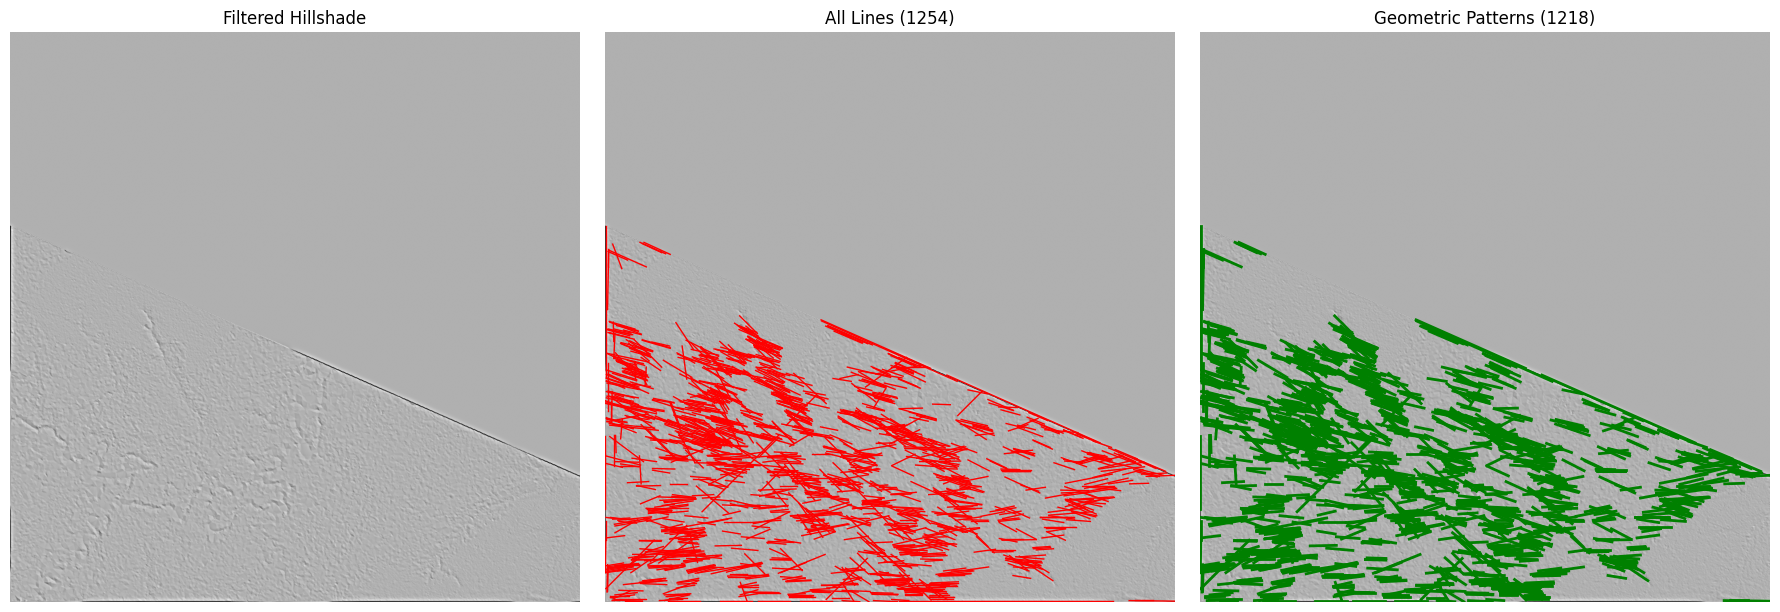

In [6]:
try:
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

    # 1. Filtered Hillshade
    axes[0].imshow(filtered_hillshade, cmap='gray')
    axes[0].set_title('Filtered Hillshade')
    axes[0].axis('off')

    # 2. All Length-Filtered Lines
    axes[1].imshow(filtered_hillshade, cmap='gray')
    if length_filtered_lines:
        for line in length_filtered_lines:
            x1, y1, x2, y2 = line[0]
            axes[1].plot([x1, x2], [y1, y2], 'r-', linewidth=1)
    axes[1].set_title(f'All Lines ({len(length_filtered_lines)})')
    axes[1].axis('off')

    # 3. Only Geometric Pattern Lines
    axes[2].imshow(filtered_hillshade, cmap='gray')
    if geometric_lines:
        for line in geometric_lines:
            x1, y1, x2, y2 = line[0]
            axes[2].plot([x1, x2], [y1, y2], 'g-', linewidth=2)
    axes[2].set_title(f'Geometric Patterns ({len(geometric_lines)})')
    axes[2].axis('off')

    plt.tight_layout()
    
    # Save the figure
    output_path = '/Users/shg/Projects/openai-a-z-challenge/geometric_pattern_results.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"Final visualization saved to {output_path}")
    
    plt.show()
except NameError as e:
    print(f"Could not generate visualization: {e}")